In [100]:
# # Display plots inline and change default figure size
# %matplotlib inline

# Package imports
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from pandas_datareader import data as datard
from datetime import datetime, timedelta
import yfinance
import matplotlib.ticker as mticker
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from mplfinance.original_flavor import candlestick_ohlc


In [79]:

stocks = ['AAPL']
#'MSFT', 'AMD' , 'FB' , 'AMZN' , 'ADSK' , 'ANSS' , 'AVGO' , 'AZN' , 'FISV' , 'GILD' , 'KHC' , 'NFLX' , 'OKTA' , 'REGN'
endDate = pd.to_datetime('today')
startDate = endDate - timedelta(days = 365 * 32 )
df = pd.DataFrame()

for stock in stocks:
  df2 = yfinance.download(stock , startDate , endDate )
  df = pd.concat([df, df2])

df



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-03-23,0.368304,0.383929,0.366071,0.377232,0.302765,227987200
1990-03-26,0.379464,0.387277,0.375000,0.377232,0.302765,128060800
1990-03-27,0.375000,0.377232,0.368304,0.375000,0.300974,84604800
1990-03-28,0.375000,0.376116,0.366071,0.368304,0.295600,102939200
1990-03-29,0.366071,0.370536,0.363839,0.367188,0.294704,96891200
...,...,...,...,...,...,...
2022-03-08,158.820007,162.880005,155.800003,157.440002,157.440002,131148300
2022-03-09,161.479996,163.410004,159.410004,162.949997,162.949997,91454900
2022-03-10,160.199997,160.389999,155.979996,158.520004,158.520004,105342000


In [ ]:
from scipy.signal import argrelextrema

def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['Close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []

    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):

            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmin())  

    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]

    p = prices.reset_index()   
    max_min['day_num'] = p[p['Date'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['Close']
    
    return max_min

smoothing = 3
window = 10


In [81]:
from collections import defaultdict

def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns

patterns = find_patterns(minmax)



In [82]:
def plot_minmax_patterns(prices, max_min, patterns, stock, window, ema):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    if len(patterns) == 0:
        pass
    else:
        num_pat = len([x for x in patterns.items()][0][1])
        f, axes = plt.subplots(1, 2, figsize=(16, 5))
        axes = axes.flatten()
        prices_ = prices.reset_index()['Close']
        axes[0].plot(prices_)
        axes[0].scatter(max_min.index, max_min, s=100, alpha=.3, color='orange')
        axes[1].plot(prices_)
        
        for name, end_day_nums in patterns.items():
            for i, tup in enumerate(end_day_nums):
                sd = tup[0]
                ed = tup[1]
                axes[1].scatter(max_min.loc[sd:ed].index,
                              max_min.loc[sd:ed].values,
                              s=200, alpha=.3)
                plt.yticks([])
        plt.tight_layout()
        plt.title('{}: {}: EMA {}, Window {} ({} patterns)'.format(stock, incr, ema, window, num_pat))

def get_results(prices, max_min, pat, stock, ema_, window_):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    #fw_list = [1, 12, 24, 36] 
    fw_list = [1, 2, 3]
    results = []
    if len(pat.items()) > 0:
        end_dates = [v for k, v in pat.items()][0]  
        for date in end_dates:  
            param_res = {'stock': stock,
                         'increment': incr,
                         'ema': ema_,
                         'window': window_, 
                         'date': date}
            for x in fw_list:
                returns = (prices['Close'].pct_change(x).shift(-x).reset_index(drop=True).dropna())
                try:
                    param_res['fw_ret_{}'.format(x)] = returns.loc[date[1]]   
                except Exception as e:
                    param_res['fw_ret_{}'.format(x)] = e
            results.append(param_res)  
    else:
        param_res = {'stock': stock,
                     'increment': incr,
                     'ema': ema_,
                     'window': window_,
                     'date': None}
        for x in fw_list:
            param_res['fw_ret_{}'.format(x)] = None   
        results.append(param_res)
    return pd.DataFrame(results)

def screener(stock_data, ema_list, window_list, plot, results):
    
    all_results = pd.DataFrame()
    
    # for stock in stock_data:
    #     prices = stock_data.iloc[stock]
    prices = stock_data
    for ema_ in ema_list:
        for window_ in window_list: 
            max_min = get_max_min(prices, smoothing=ema_, window_range=window_)
            pat = find_patterns(max_min)
            if plot == True:
                plot_minmax_patterns(prices, max_min, pat, 'AAPL', window_, ema_)
                
            if results == True:
                all_results = pd.concat([all_results, get_results(prices, max_min, pat, 'AAPL', ema_, window_)], axis=0)
                
    if results == True:
        return all_results.reset_index(drop=True)

In [ ]:
resampled_data = df.resample('60T', closed='right', label='right').agg({'Open': 'first',
                                                                         'High': 'max',
                                                                         'Low': 'min',
                                                                         'Close': 'last'}).dropna()


In [106]:
ema_list = [10 , 20 , 50]
window_list = [10 , 20 , 50]

results = screener(resampled_data , ema_list , window_list , False, True)

In [105]:
results

,stock,increment,ema,window,date,fw_ret_1,fw_ret_2,fw_ret_3
0,AAPL,0.0,10,10,"(1650, 1692)",0.041448,0.041448,0.036267
1,AAPL,0.0,10,10,"(1924, 1987)",0.035334,0.0318,0.035334
2,AAPL,0.0,10,10,"(2133, 2179)",-0.012923,-0.016154,-0.053311
3,AAPL,0.0,10,10,"(2458, 2492)",0.045541,0.09298,0.154333
4,AAPL,0.0,10,10,"(5781, 5832)",0.013361,0.010283,0.032832
5,AAPL,0.0,10,10,"(6329, 6382)",-0.000479,-0.00575,-0.019566
6,AAPL,0.0,10,10,"(6998, 7055)",0.047472,0.020614,0.009337
7,AAPL,0.0,10,20,"(6990, 7055)",0.047472,0.020614,0.009337
8,AAPL,0.0,10,30,"(7314, 7398)",0.01893,0.029482,0.052188
9,AAPL,0.0,20,10,"(2458, 2492)",0.045541,0.09298,0.154333


In [84]:
max_val = 0
for i in range(len(results)):
    if (results.iloc[i].values[4] != None):
        x , y = results.iloc[i].values[4]
        max_val = max(max_val , y-x)

max_val

95

In [85]:
cor_arr = []
for i in range(len(results)):
    if (results.iloc[i].values[4] != None):
        x , y = results.iloc[i].values[4]
        gap = max_val - y + x 
        mid = int(gap / 2)
        x = x - mid
        y = y + gap - mid
        cor_arr.append([x,y])

In [86]:
# Timestep = List of candles seqeuence
# Items = Candlestick
# Features = High, Low, Open, Close parametes
def graph_data_ohlc(dataset):
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date = range(len(closep))

    x = 0
    y = len(date)
    ohlc = []

    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x += 1

    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#77d879', colordown='#db3f3f')

    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
        
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)


    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)    
    plt.show()

In [87]:
# convert the price data in to actual candlestick parameters. Each candle has 4 parameters
# Open	High Low	Close -< conversion_array
# Size of the body measured by pips
# Size of the upper wicks measured by pips
# Size of the lower wicks measured by pips
# Type of the candle (Bullish or Bearish)(Green or Red)(0 or 1)


#Handle
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]

    if conversion_array[3]>conversion_array[0]:
        candle_type=1
        wicks_up=conversion_array[1]-conversion_array[3]
        wicks_down=conversion_array[2]-conversion_array[0]
        body_size=conversion_array[3]-conversion_array[0]

    else:
        candle_type=0
        wicks_up=conversion_array[1]-conversion_array[0]
        wicks_down=conversion_array[2]-conversion_array[3]
        body_size=conversion_array[1]-conversion_array[3]


    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000, 4)
    candlestick_data[2]=round(round(wicks_down,5)*10000, 4)
    candlestick_data[3]=round(round(body_size,5)*10000, 4)

    return candlestick_data

In [88]:
del df['Volume']
del df['Adj Close']

In [89]:
X_raw = []
X = []
Y = []
for row in cor_arr:
    tmp = []
    mean = []
    prediction = 0
    X_raw.append(df.values[row[0] : row[1]]) # append raw value
    for idx in range(row[0] , row[1]):
        converted_data = ohlc_to_candlestick(df.values[idx])
        tmp.append(converted_data) # convert data to cds 

    for idx in range(row[1], row[1] + 14):
        mean.append(df.values[idx][3])

    X.append(tmp)
    if (np.mean(mean) > df.values[row[1]][3]):
        prediction = 1

    Y.append(prediction)

X = np.asarray(X)
X_raw = np.asarray(X_raw)
Y = np.asarray(Y)

In [90]:
unique, counts = np.unique(Y, return_counts=True)
predictions_type = dict(zip(unique, counts))
print('Bull: ' + str((predictions_type[1])) + ' percent: ' + str(round((predictions_type[1]*100)/len(Y),2)) + '%')
print('Bear: ' + str((predictions_type[0])) + ' percent: ' + str(round((predictions_type[0]*100)/len(Y),2)) + '%')
print('Total: ' + str(len(Y)))

Bull: 11 percent: 57.89%
Bear: 8 percent: 42.11%
Total: 19


In [91]:
print('Shape of X ' + str(X.shape))
print('Shape of Y ' + str(Y.shape))
print('Shape of X raw ohlc ' + str(X_raw.shape))

Shape of X (19, 95, 4)
Shape of Y (19,)
Shape of X raw ohlc (19, 95, 4)


In [92]:
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(layers.LSTM(units = 50,return_sequences=True, input_shape = (None, X.shape[-1])))
model.add(Dropout(0.1))
model.add(layers.LSTM(units = 50))
model.add(Dropout(0.1))
model.add(layers.Dense(units = 1,activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [93]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.5 , shuffle = False)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5 , shuffle = False)
X_train_raw, X_val_and_test_raw = train_test_split(X_raw, test_size=0.5 , shuffle = False )
X_val_raw, X_test_raw = train_test_split(X_val_and_test_raw, test_size=0.5 , shuffle = False)


In [94]:
history = model.fit(X_train, Y_train, epochs= 20 ,validation_data=(X_val, Y_val))

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.7440 - acc: 0.4444 - val_loss: 0.6678 - val_acc: 0.6000
Epoch 2/20
1/1 [==============================] - 0s 61ms/step - loss: 0.6741 - acc: 0.5556 - val_loss: 0.6520 - val_acc: 0.6000
Epoch 3/20
1/1 [==============================] - 0s 57ms/step - loss: 0.6571 - acc: 0.6667 - val_loss: 0.6240 - val_acc: 0.8000
Epoch 4/20
1/1 [==============================] - 0s 57ms/step - loss: 0.6285 - acc: 0.7778 - val_loss: 0.6094 - val_acc: 0.8000
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 0.5924 - acc: 0.8889 - val_loss: 0.5969 - val_acc: 0.8000
Epoch 6/20
1/1 [==============================] - 0s 62ms/step - loss: 0.5501 - acc: 0.8889 - val_loss: 0.5744 - val_acc: 0.8000
Epoch 7/20
1/1 [==============================] - 0s 56ms/step - loss: 0.5459 - acc: 0.8889 - val_loss: 0.5848 - val_acc: 0.8000
Epoch 8/20
1/1 [==============================] - 0s 64ms/step - loss: 0.5196 - acc: 0.8889 - val_l

In [99]:
model.save('HAS_inversed.h5')

In [102]:
model = keras.models.load_model('HAS_inversed.h5')

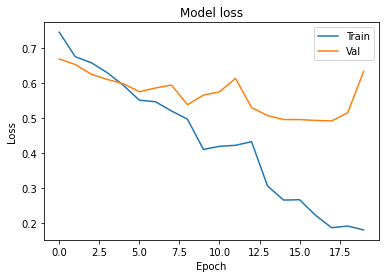

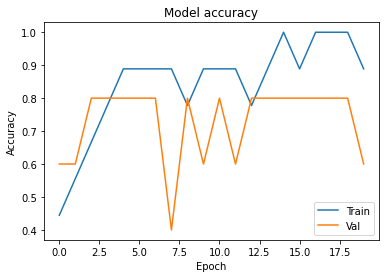

In [95]:
# Chart 1 - Model Loss
#plt.subplot(331)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


# Chart 2 - Model Accuracy
#plt.subplot(332)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [96]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

1/1 [==============================] - 0s 26ms/step - loss: 1.3245 - acc: 0.2000
Test accuracy: 0.20000000298023224


In [97]:
X_test_raw.shape

(5, 95, 4)

Correct trend is Bullish
Model prediction trend is Bullish
WON


C:\Python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


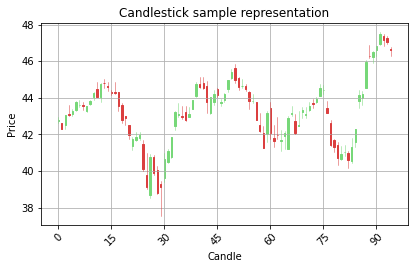

Correct trend is Bearish
Model prediction trend is Bullish
LOST


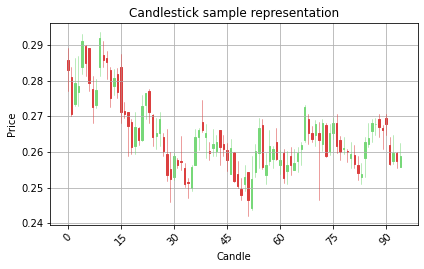

Correct trend is Bullish
Model prediction trend is Bearish
LOST


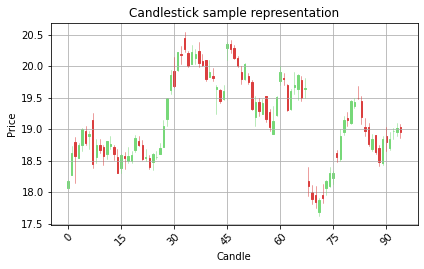

Correct trend is Bullish
Model prediction trend is Bearish
LOST


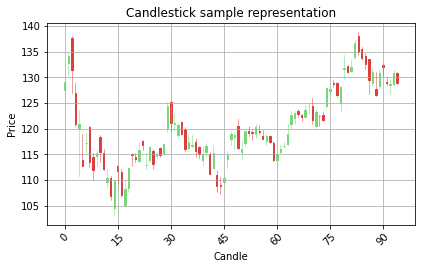

Won: 1 Lost: 3
Success rate: 25.0%


In [98]:

counter = 0
won = 0
lost = 0
test = model.predict(X_test)
alpha_distance = 0.35

for a in test:
    if a > (1-alpha_distance) or a < alpha_distance :
        if Y_test[counter] == 1:print('Correct trend is Bullish')
        if Y_test[counter] == 0:print('Correct trend is Bearish')
        if a > (1-alpha_distance):print('Model prediction trend is Bullish')
        if a < alpha_distance:print('Model prediction trend is Bearish')

        if (a > (1-alpha_distance) and Y_test[counter] == 1) or (a < alpha_distance and Y_test[counter] == 0):
            won=won+1
            print('WON')
        else:
            print('LOST')
            lost=lost+1

        d_arr = np.empty(( 0 ,4))

        d_arr = np.append(d_arr , X_test_raw[counter] , axis= 0 )
        

        graph_data_ohlc(d_arr)

    counter=counter+1
    
print('Won: ' + str(won) + ' Lost: ' + str(lost))
print('Success rate: ' + str(round((won*100)/(won+lost),2)) + '%')
